## Imports and Definitions

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets, metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

def pad_image(img):
    padded_image = []
    for row in img:
        padded_image.append(np.concatenate(([0], np.concatenate((row, [0])))))
    row_size = len(img[0])
    padded_row = [[0.] * (row_size + 2)]
    new_image = np.concatenate((padded_row, np.concatenate((padded_image, padded_row))))
    return new_image

dataset = datasets.load_digits()
len(dataset.images)

1797

In [9]:
def cross_entropy(y_true, y_pred):
    threshold = 1e-8
    y_pred = np.clip(y_pred, threshold, 1 - threshold)
    return -np.sum(y_true * np.log2(y_pred))

def cross_entropy_prime(y_true, y_pred):
    threshold = 1e-8
    y_pred = np.clip(y_pred, threshold, 1 - threshold)
    return (y_true / (y_pred * np.log(2)))

def mse(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))

def mse_prime(y_true, y_pred):
    threshold = 1e-8
    y_pred = np.clip(y_pred, threshold, 1 - threshold)
    return 2*(y_pred-y_true)/y_true.size

def linear(x):
    return x

def linear_prime(x):
    return np.ones(x.shape)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    return sigmoid(x) * (1 - sigmoid(x))

def relu(x):
    x[x < 0] = 0
    return x

def relu_prime(x):
    x[x < 0] = 0
    x[x > 0] = 1
    return x

## Preprocessing

In [3]:
data, labels = dataset.images, dataset.target
data = np.array([pad_image(image) for image in data])
data = data.reshape((data.shape[0], 1, -1))
labels = labels.reshape(-1, 1)
labels = OneHotEncoder().fit_transform(labels).toarray()

X_learn, X_test, Y_learn, Y_test = train_test_split(data, labels, test_size=0.2, stratify=labels)

In [4]:
NUM_EPOCHS = 30
LEARNING_RATE = 0.1

## Perceptron

In [5]:
class Perceptron():
    def __init__(self, input_size, output_size):
        self.weights = np.divide(np.random.rand(input_size, output_size) - 0.5, input_size * output_size)
        self.bias = np.divide(np.random.rand(1, output_size) - 0.5, output_size)

    def forward(self, input_data):
        self.X = input_data
        self.Y = np.dot(self.X, self.weights) + self.bias
        return self.Y

    def backward(self, Y_error, learning_rate):
        X_error = np.dot(Y_error, self.weights.T)
        W_error = np.dot(self.X.T, Y_error)

        self.weights -= learning_rate * W_error
        self.bias -= learning_rate * Y_error
        return X_error

class ActivationLayer():
    def __init__(self, activation_function, activation_function_prime):
        self.activation = activation_function
        self.activation_prime = activation_function_prime

    def forward(self, input_data):
        self.X = input_data
        self.Y = self.activation(self.X)
        return self.Y

    def backward(self, Y_error, learning_rate):
        return self.activation_prime(self.X) * Y_error

In [193]:
def training(model, learning_rate=LEARNING_RATE):
    training_losses = []
    validation_losses = []
        
    for epoch in range(NUM_EPOCHS):
        epoch_training_loss = 0
        epoch_validation_loss = 0
        # Stochastize the training/validation dataset
        X_train, X_val, Y_train, Y_val = train_test_split(X_learn, Y_learn, test_size=0.25, stratify=Y_learn)
        
        for i in range(len(X_train)):
            output = X_train[i]
            for layer in model.layers:
                output = layer.forward(output)

            epoch_training_loss += cross_entropy(Y_train[i], output)

            #used mse_prime here because cross_entropy_prime works but performs way worse
            error = mse_prime(Y_train[i], output)
            for layer in reversed(model.layers):
                error = layer.backward(error, learning_rate)

        for j in range(len(X_val)):
            output = X_val[j]
            for layer in model.layers:
                output = layer.forward(output)

            epoch_validation_loss += cross_entropy(Y_val[j], output)

        training_losses.append(epoch_training_loss)
        validation_losses.append(epoch_validation_loss)
        print(f'Epoch {epoch+1} training loss: {epoch_training_loss}   validation loss: {epoch_validation_loss}')

    fig, ax = plt.subplots()
    ax.scatter(range(1, len(training_losses)+1), training_losses, c='blue', label='Training')
    ax.scatter(range(1, len(validation_losses)+1), validation_losses, c='red', label='Validation')

    ax.legend()
    ax.grid(True)

    plt.show()

def testing(model):
    y_pred = []
    y_true = []
    for k in range(len(X_test)):
        output = X_test[k]
        for layer in model.layers:
            output = layer.forward(output)

        y_pred.append(np.argmax(output))
        y_true.append(np.argmax(Y_test[k]))

    print(f'F1 Score: {metrics.f1_score(y_true, y_pred, average="macro")}')
    print(f'Confusion Matrix:\n {metrics.confusion_matrix(y_true, y_pred)}')


In [7]:
class Network:
    def __init__(self):
        self.layers = []

    def set_architecture(self, layers):
        self.layers = layers

Epoch 1 training loss: 7377.027493030502   validation loss: 3192.5214816281937
Epoch 2 training loss: 4632.924976402795   validation loss: 1439.8685199543006
Epoch 3 training loss: 3962.437595058296   validation loss: 1491.428371304238
Epoch 4 training loss: 3056.7993489297687   validation loss: 1249.9545829444721
Epoch 5 training loss: 2817.2865055190023   validation loss: 1968.923218179952
Epoch 6 training loss: 2923.879245793197   validation loss: 637.810199065834
Epoch 7 training loss: 2764.763266871847   validation loss: 903.5644465125537
Epoch 8 training loss: 2577.852073917431   validation loss: 690.9610485551773
Epoch 9 training loss: 2344.9652076634884   validation loss: 692.5828044753044
Epoch 10 training loss: 2316.4922846803315   validation loss: 903.5644465125536
Epoch 11 training loss: 2261.7871972503544   validation loss: 372.0559516191092
Epoch 12 training loss: 2421.267421399554   validation loss: 639.6650048842222
Epoch 13 training loss: 1997.779152639502   validation

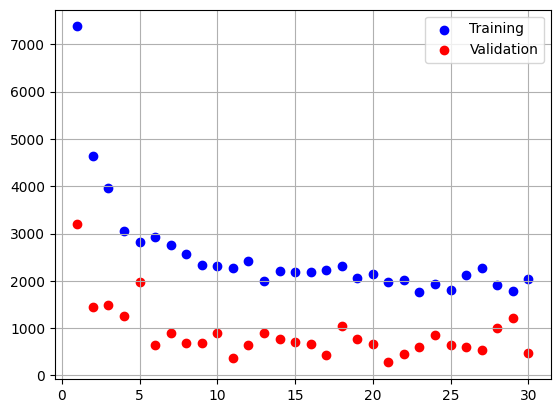

F1 Score: 0.9536104569666213
Confusion Matrix:
 [[36  0  0  0  0  0  0  0  0  0]
 [ 0 35  0  0  0  0  0  0  2  0]
 [ 0  3 31  0  0  0  0  0  1  0]
 [ 0  0  0 35  0  0  0  1  1  0]
 [ 0  1  0  0 34  0  0  1  0  0]
 [ 1  1  0  0  0 34  0  0  0  0]
 [ 0  1  0  0  0  0 34  0  1  0]
 [ 0  0  0  0  0  0  0 35  1  0]
 [ 0  0  0  0  0  0  0  0 35  0]
 [ 0  0  0  0  0  0  0  1  1 34]]


In [15]:
perceptron_model = Network()
perceptron_model.set_architecture([Perceptron(10 * 10, 10), ActivationLayer(linear, linear_prime)])
training(perceptron_model)
testing(perceptron_model)

Epoch 1 training loss: 3725.47543927955   validation loss: 1193.38485366232
Epoch 2 training loss: 2803.2067493261184   validation loss: 1053.4806634185247
Epoch 3 training loss: 2540.2734401318876   validation loss: 758.7012534116642
Epoch 4 training loss: 2270.5271248290683   validation loss: 702.3685651062684
Epoch 5 training loss: 1992.9725143448347   validation loss: 572.7192193584442
Epoch 6 training loss: 1268.19729889842   validation loss: 368.39195642564596
Epoch 7 training loss: 1195.7468769142465   validation loss: 492.1297913204663
Epoch 8 training loss: 1229.4689245652728   validation loss: 524.6288647916249
Epoch 9 training loss: 1210.965071008108   validation loss: 568.0798510150518
Epoch 10 training loss: 1250.3142259307217   validation loss: 336.5093828264845
Epoch 11 training loss: 1154.7895356635624   validation loss: 145.88026540045925
Epoch 12 training loss: 938.163325312355   validation loss: 355.90661598893655
Epoch 13 training loss: 1069.4951310732467   validati

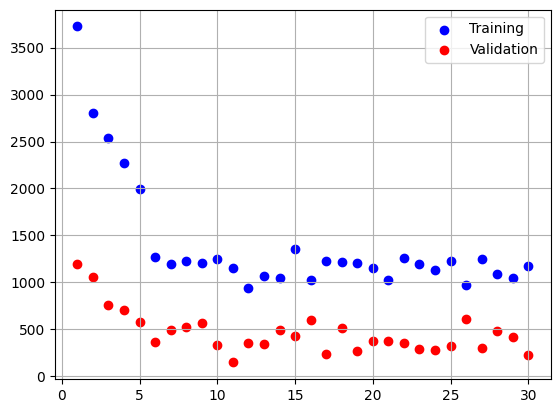

F1 Score: 0.9552160106509113
Confusion Matrix:
 [[36  0  0  0  0  0  0  0  0  0]
 [ 0 36  0  0  0  0  0  0  0  1]
 [ 0  0 35  0  0  0  0  0  0  0]
 [ 0  1  1 35  0  0  0  0  0  0]
 [ 0  0  0  0 34  1  0  1  0  0]
 [ 0  0  1  0  0 34  0  0  0  1]
 [ 0  1  0  0  0  0 34  0  1  0]
 [ 0  0  0  0  1  0  0 34  1  0]
 [ 0  0  0  1  1  3  0  0 30  0]
 [ 0  0  0  0  0  0  0  0  0 36]]


In [16]:
perceptron_model = Network()
perceptron_model.set_architecture([Perceptron(10 * 10, 10), ActivationLayer(sigmoid, sigmoid_prime)])
training(perceptron_model)
testing(perceptron_model)

Epoch 1 training loss: 14266.401000177546   validation loss: 2840.249903491869
Epoch 2 training loss: 8036.143961892645   validation loss: 1752.8414687770985
Epoch 3 training loss: 7333.010648151219   validation loss: 1501.445490558079
Epoch 4 training loss: 6086.6898498203   validation loss: 1848.0674682223216
Epoch 5 training loss: 5837.179400449485   validation loss: 1694.9268899331953
Epoch 6 training loss: 5485.164201470627   validation loss: 2592.110544624951
Epoch 7 training loss: 4490.567791918629   validation loss: 1943.3279355091079
Epoch 8 training loss: 4784.28808804282   validation loss: 2093.152330678757
Epoch 9 training loss: 4638.768979925984   validation loss: 996.578428466209
Epoch 10 training loss: 4039.4225258636166   validation loss: 1445.0387212760031
Epoch 11 training loss: 4886.392029767797   validation loss: 597.9470570797251
Epoch 12 training loss: 4087.5511758989724   validation loss: 2391.788228318902
Epoch 13 training loss: 4335.367480231034   validation lo

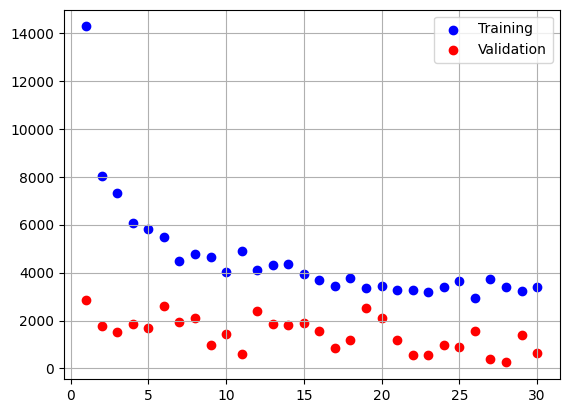

F1 Score: 0.9175355547569264
Confusion Matrix:
 [[36  0  0  0  0  0  0  0  0  0]
 [ 5 31  0  0  0  0  0  0  1  0]
 [ 0  0 35  0  0  0  0  0  0  0]
 [ 2  0  2 32  0  0  0  1  0  0]
 [ 0  0  0  0 35  0  1  0  0  0]
 [ 0  0  1  1  0 34  0  0  0  0]
 [ 1  0  0  0  0  0 35  0  0  0]
 [ 1  0  0  0  1  0  0 34  0  0]
 [ 3  1  1  0  0  0  0  0 30  0]
 [ 0  0  0  0  0  0  0  0  8 28]]


In [37]:
perceptron_model = Network()
perceptron_model.set_architecture([Perceptron(10 * 10, 10), ActivationLayer(relu, relu_prime)])
training(perceptron_model)
testing(perceptron_model)

## Neural Network

In [17]:
class FCLayer():
    def __init__(self, input_size, output_size):
        self.weights = np.divide(np.random.rand(input_size, output_size) - 0.5, input_size * output_size)
        self.bias = np.divide(np.random.rand(1, output_size) - 0.5, output_size)

    def forward(self, input_data):
        self.X = input_data
        self.Y = np.dot(self.X, self.weights) + self.bias
        return self.Y

    def backward(self, Y_error, learning_rate):
        X_error = np.dot(Y_error, self.weights.T)
        W_error = np.dot(self.X.T, Y_error)

        self.weights -= learning_rate * W_error
        self.bias -= learning_rate * Y_error
        return X_error

Epoch 1 training loss: 4253.801684437684   validation loss: 1230.978578819267
Epoch 2 training loss: 3656.2412527134825   validation loss: 1212.0322808013193
Epoch 3 training loss: 3647.064723891082   validation loss: 1226.1721907701847
Epoch 4 training loss: 3644.4878940756657   validation loss: 1228.4670452763457
Epoch 5 training loss: 3652.415380638261   validation loss: 1210.3152886482746
Epoch 6 training loss: 3213.2113277940643   validation loss: 992.7018170532277
Epoch 7 training loss: 3192.814199467376   validation loss: 1033.0063632373951
Epoch 8 training loss: 2949.2540280509093   validation loss: 978.2987918129296
Epoch 9 training loss: 2639.389785292333   validation loss: 688.2254919820158
Epoch 10 training loss: 3063.7977537916763   validation loss: 801.8360216043526
Epoch 11 training loss: 2950.737232851326   validation loss: 1628.0367037331025
Epoch 12 training loss: 3974.509284783406   validation loss: 1739.63086926651
Epoch 13 training loss: 3714.9870142657455   valida

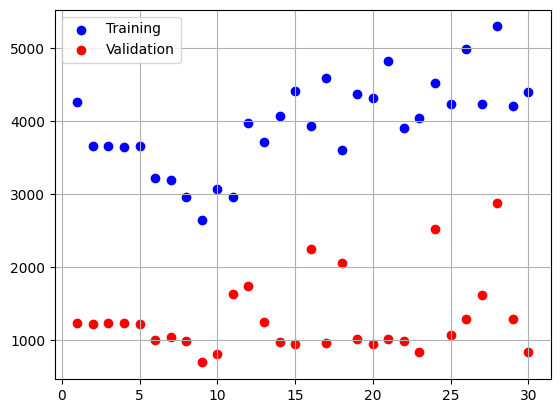

F1 Score: 0.6601605751977269
Confusion Matrix:
 [[35  0  0  0  1  0  0  0  0  0]
 [ 0 35  0  0  0  0  0  2  0  0]
 [ 0  2 29  3  0  0  0  1  0  0]
 [ 1  0  1 29  0  0  0  2  0  4]
 [ 0  1  0  0 35  0  0  0  0  0]
 [ 0  2  0  1  0  1  2 11  4 15]
 [ 0  2  0  0  0  0 34  0  0  0]
 [ 0  0  0  0  0  0  0 36  0  0]
 [ 0 10  0  0  0  0  2  3  5 15]
 [ 4  1  0  4  0  1  1  9  1 15]]


In [39]:
neural_network = Network()
neural_network.set_architecture(
    [FCLayer(100, 50), 
    ActivationLayer(linear, linear_prime),
    FCLayer(50, 25), 
    ActivationLayer(linear, linear_prime),
    FCLayer(25, 10), 
    ActivationLayer(linear, linear_prime),
    ]
)
training(neural_network)
testing(neural_network)

Epoch 1 training loss: 3092.6709520941813   validation loss: 1188.4660856538237
Epoch 2 training loss: 3588.3023694829685   validation loss: 1200.5048155054494
Epoch 3 training loss: 3600.2198134910677   validation loss: 1201.2731079012465
Epoch 4 training loss: 3599.2413537621974   validation loss: 1199.970865086253
Epoch 5 training loss: 3599.3688960175377   validation loss: 1200.462207768585
Epoch 6 training loss: 3598.7297100210976   validation loss: 1200.3073431264127
Epoch 7 training loss: 3599.6195582240316   validation loss: 1200.6008162124724
Epoch 8 training loss: 3598.701324537905   validation loss: 1200.8530898221395
Epoch 9 training loss: 3598.068246007269   validation loss: 1200.446478160433
Epoch 10 training loss: 3598.2169465651837   validation loss: 1201.4790520048093
Epoch 11 training loss: 3599.7712817965476   validation loss: 1200.1973190441627
Epoch 12 training loss: 3597.5146276280557   validation loss: 1200.126545277634
Epoch 13 training loss: 3599.566440271563  

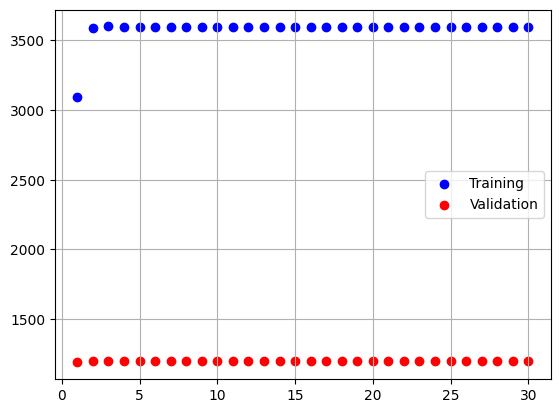

F1 Score: 0.017721518987341773
Confusion Matrix:
 [[ 0  0  0  0  0  0  0  0 36  0]
 [ 0  0  0  0  0  0  0  0 37  0]
 [ 0  0  0  0  0  0  0  0 35  0]
 [ 0  0  0  0  0  0  0  0 37  0]
 [ 0  0  0  0  0  0  0  0 36  0]
 [ 0  0  0  0  0  0  0  0 36  0]
 [ 0  0  0  0  0  0  0  0 36  0]
 [ 0  0  0  0  0  0  0  0 36  0]
 [ 0  0  0  0  0  0  0  0 35  0]
 [ 0  0  0  0  0  0  0  0 36  0]]


In [40]:
neural_network = Network()
neural_network.set_architecture(
    [FCLayer(10 * 10, 50), 
    ActivationLayer(sigmoid, sigmoid_prime),
    FCLayer(50, 25), 
    ActivationLayer(sigmoid, sigmoid_prime),
    FCLayer(25, 10), 
    ActivationLayer(sigmoid, sigmoid_prime),
    ]
)
training(neural_network)
testing(neural_network)

Epoch 1 training loss: 4081.063283191159   validation loss: 1214.2233869225845
Epoch 2 training loss: 3651.917226045665   validation loss: 1218.9947645809668
Epoch 3 training loss: 3671.1265627743305   validation loss: 1212.894949792822
Epoch 4 training loss: 3665.1040543871836   validation loss: 1227.7068531847146
Epoch 5 training loss: 3653.456731770988   validation loss: 1233.7661123276216
Epoch 6 training loss: 3657.6290194645226   validation loss: 1208.3406035955313
Epoch 7 training loss: 3655.8369748052864   validation loss: 1212.1782967727218
Epoch 8 training loss: 3396.048054044279   validation loss: 909.4155331306353
Epoch 9 training loss: 2904.6377045005447   validation loss: 761.3807102733451
Epoch 10 training loss: 2436.013558651782   validation loss: 1233.8184830579485
Epoch 11 training loss: 2881.0927095263346   validation loss: 718.9242341030291
Epoch 12 training loss: 1816.703259426256   validation loss: 1251.1663967554562
Epoch 13 training loss: 1871.487079940566   val

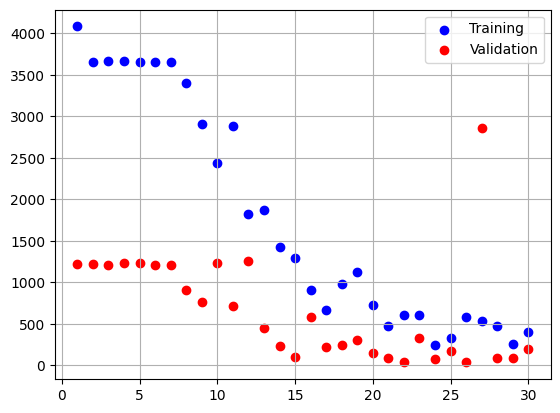

F1 Score: 0.9462387597711223
Confusion Matrix:
 [[36  0  0  0  0  0  0  0  0  0]
 [ 0 37  0  0  0  0  0  0  0  0]
 [ 0  0 35  0  0  0  0  0  0  0]
 [ 1  0  1 29  0  1  0  1  3  1]
 [ 0  0  0  0 35  0  0  0  0  1]
 [ 1  0  1  0  0 34  0  0  0  0]
 [ 0  0  0  0  0  0 36  0  0  0]
 [ 0  0  0  0  0  0  0 36  0  0]
 [ 0  3  1  0  0  1  0  0 30  0]
 [ 3  0  0  0  0  0  0  0  0 33]]


In [41]:
neural_network = Network()
neural_network.set_architecture(
    [FCLayer(10 * 10, 50), 
    ActivationLayer(relu, relu_prime),
    FCLayer(50, 25), 
    ActivationLayer(relu, relu_prime),
    FCLayer(25, 10), 
    ActivationLayer(relu, relu_prime),
    ]
)
training(neural_network)
testing(neural_network)

## Convolutional Neural Network

In [199]:
class ConvLayer():
    def __init__(self, input_channels, output_channels, kernel_size, stride=1):
        self.weights = np.divide(np.random.rand(kernel_size, kernel_size, input_channels, output_channels) - 0.5,
                                 output_channels * input_channels * kernel_size * kernel_size)
        self.bias = np.divide(np.random.rand(output_channels) - 0.5, output_channels)
        self.stride = stride

    def forward(self, input_data):
        self.X = input_data
        input_shape = input_data.shape
        self.Y = np.zeros((((input_shape[0] - self.weights.shape[0]) // self.stride) + 1,
                           ((input_shape[1] - self.weights.shape[1]) // self.stride) + 1,
                           self.weights.shape[3])
        )
        output_shape = self.Y.shape
        weight_shape = self.weights.shape

        for height in range(output_shape[0]):
            for width in range(output_shape[1]):
                start_height = height * self.stride
                end_height = start_height + weight_shape[0]
                start_width = width * self.stride
                end_width = start_width + weight_shape[1]

                self.Y[height, width, :] = np.sum(
                    input_data[start_height:end_height, start_width:end_width, :, np.newaxis] *
                    self.weights[:, :, :, :],
                    axis=(0, 1, 2)
                )

        return self.Y + self.bias

    def backward(self, Y_error, learning_rate):
        W_error = np.zeros(self.weights.shape)
        X_error = np.zeros(self.X.shape)
        input_shape = Y_error.shape
        output_shape = X_error.shape
        weight_shape = self.weights.shape

        for height in range(input_shape[0]):
            for width in range(input_shape[1]):
                start_height = height * self.stride
                end_height = start_height + weight_shape[0]
                start_width = width * self.stride
                end_width = start_width + weight_shape[1]

                X_error[start_height:end_height, start_width:end_width, :] += np.sum(
                    self.weights[:, :, :, :] *
                    Y_error[height:height+1, width:width+1, np.newaxis, :],
                    axis=3
                )
                W_error += np.sum(
                    self.X[start_height:end_height, start_width:end_width, :, np.newaxis] *
                    Y_error[height:height+1, width:width+1, np.newaxis, :]
                )

        self.weights -= learning_rate * W_error
        self.bias -= learning_rate * Y_error.sum(axis=(0, 1))
        return X_error

class Flatten():
    def __init__(self):
        pass

    def forward(self, input_data):
        self.X = input_data
        return input_data.reshape((1, -1))

    def backward(self, Y_error, learning_rate):
        return np.reshape(Y_error, self.X.shape)

class To2D():
    def __init__(self, new_shape):
        self.shape = new_shape

    def forward(self, input_data):
        self.X = input_data
        return np.reshape(input_data, self.shape)

    def backward(self, Y_error, learning_rate):
        return np.reshape(Y_error, self.X.shape)

    

C:\Users\jaken\AppData\Local\Temp\ipykernel_17132\3319674838.py:48: RuntimeWarning: overflow encountered in multiply
  self.weights[:, :, :, :] *
C:\Users\jaken\AppData\Local\Temp\ipykernel_17132\3319674838.py:26: RuntimeWarning: overflow encountered in multiply
  input_data[start_height:end_height, start_width:end_width, :, np.newaxis] *
C:\Users\jaken\AppData\Local\Temp\ipykernel_17132\3319674838.py:53: RuntimeWarning: overflow encountered in multiply
  self.X[start_height:end_height, start_width:end_width, :, np.newaxis] *
C:\Users\jaken\AppData\Local\Temp\ipykernel_17132\3319674838.py:52: RuntimeWarning: overflow encountered in add
  W_error += np.nan_to_num(np.sum(
c:\Users\jaken\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
c:\Users\jaken\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:86: Runtime

Epoch 1 training loss: nan   validation loss: nan
Epoch 2 training loss: nan   validation loss: nan
Epoch 3 training loss: nan   validation loss: nan
Epoch 4 training loss: nan   validation loss: nan
Epoch 5 training loss: nan   validation loss: nan
Epoch 6 training loss: nan   validation loss: nan
Epoch 7 training loss: nan   validation loss: nan
Epoch 8 training loss: nan   validation loss: nan
Epoch 9 training loss: nan   validation loss: nan
Epoch 10 training loss: nan   validation loss: nan
Epoch 11 training loss: nan   validation loss: nan
Epoch 12 training loss: nan   validation loss: nan
Epoch 13 training loss: nan   validation loss: nan
Epoch 14 training loss: nan   validation loss: nan
Epoch 15 training loss: nan   validation loss: nan
Epoch 16 training loss: nan   validation loss: nan
Epoch 17 training loss: nan   validation loss: nan
Epoch 18 training loss: nan   validation loss: nan
Epoch 19 training loss: nan   validation loss: nan
Epoch 20 training loss: nan   validation

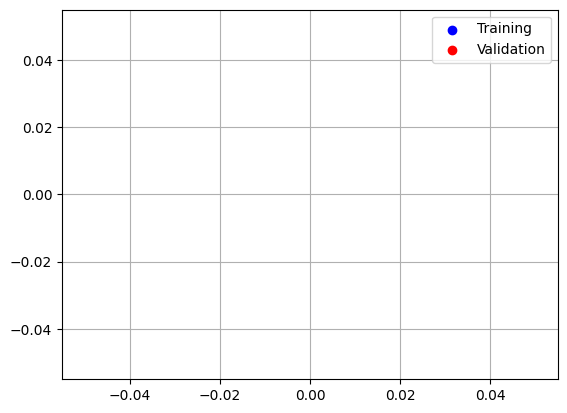

F1 Score: 0.018639798488664986
Confusion Matrix:
 [[ 0 36  0  0  0  0  0  0  0  0]
 [ 0 37  0  0  0  0  0  0  0  0]
 [ 0 35  0  0  0  0  0  0  0  0]
 [ 0 37  0  0  0  0  0  0  0  0]
 [ 0 36  0  0  0  0  0  0  0  0]
 [ 0 36  0  0  0  0  0  0  0  0]
 [ 0 36  0  0  0  0  0  0  0  0]
 [ 0 36  0  0  0  0  0  0  0  0]
 [ 0 35  0  0  0  0  0  0  0  0]
 [ 0 36  0  0  0  0  0  0  0  0]]


In [200]:
neural_network = Network()
neural_network.set_architecture(
    [To2D((10, 10, 1)),
    ConvLayer(1, 3, 4),
    ActivationLayer(linear, linear_prime),
    ConvLayer(3, 9, 3), 
    ActivationLayer(linear, linear_prime),
    Flatten(),
    FCLayer(225, 10), 
    ActivationLayer(linear, linear_prime),
    ]
)
training(neural_network)
testing(neural_network)

Epoch 1 training loss: 3718.8895143017903   validation loss: 1266.713521292881
Epoch 2 training loss: 3667.573336732448   validation loss: 1203.0038151294066
Epoch 3 training loss: 3637.6919936085005   validation loss: 1207.6322742146192
Epoch 4 training loss: 3598.8202012778797   validation loss: 1149.7941114227558
Epoch 5 training loss: 3440.6041320912254   validation loss: 1119.7350982014696
Epoch 6 training loss: 3238.574613983007   validation loss: 1046.5517640136334
Epoch 7 training loss: 3184.3390540004393   validation loss: 1074.4694442800828
Epoch 8 training loss: 3015.1213712375993   validation loss: 880.7887298574007
Epoch 9 training loss: 2714.669127057533   validation loss: 890.5040918236488
Epoch 10 training loss: 2710.0907169283214   validation loss: 832.8518966013156
Epoch 11 training loss: 2414.85348088216   validation loss: 851.0109379841625
Epoch 12 training loss: 2602.3701687441257   validation loss: 709.403373399958
Epoch 13 training loss: 2203.260724099293   valid

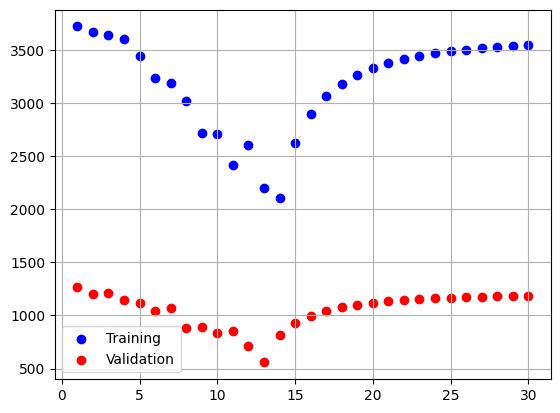

F1 Score: 0.01818181818181818
Confusion Matrix:
 [[ 0  0  0  0  0  0 36  0  0  0]
 [ 0  0  0  0  0  0 37  0  0  0]
 [ 0  0  0  0  0  0 35  0  0  0]
 [ 0  0  0  0  0  0 37  0  0  0]
 [ 0  0  0  0  0  0 36  0  0  0]
 [ 0  0  0  0  0  0 36  0  0  0]
 [ 0  0  0  0  0  0 36  0  0  0]
 [ 0  0  0  0  0  0 36  0  0  0]
 [ 0  0  0  0  0  0 35  0  0  0]
 [ 0  0  0  0  0  0 36  0  0  0]]


In [197]:
neural_network = Network()
neural_network.set_architecture(
    [To2D((10, 10, 1)),
    ConvLayer(1, 3, 4), 
    ActivationLayer(sigmoid, sigmoid_prime),
    ConvLayer(3, 9, 3), 
    ActivationLayer(sigmoid, sigmoid_prime),
    Flatten(),
    FCLayer(225, 10), 
    ActivationLayer(sigmoid, sigmoid_prime),
    ]
)
training(neural_network)
testing(neural_network)

Epoch 1 training loss: 11233.155968009001   validation loss: 3691.7420372189194
Epoch 2 training loss: 11183.251242667457   validation loss: 3685.8230622843353
Epoch 3 training loss: 11137.671120428278   validation loss: 3772.025786648326
Epoch 4 training loss: 11150.815753396422   validation loss: 3745.9889534419276
Epoch 5 training loss: 11144.48016441048   validation loss: 3763.813232647677
Epoch 6 training loss: 11133.977502876674   validation loss: 3766.541641398856
Epoch 7 training loss: 11147.629578968597   validation loss: 3745.9358217542367
Epoch 8 training loss: 11146.814534902574   validation loss: 3725.682354785457
Epoch 9 training loss: 11150.694856318276   validation loss: 3722.129751093066
Epoch 10 training loss: 11142.65524358228   validation loss: 3726.866364174896
Epoch 11 training loss: 11158.157843352783   validation loss: 3759.3607716492247
Epoch 12 training loss: 11177.508526856622   validation loss: 3708.280076092968
Epoch 13 training loss: 11181.714521848502   v

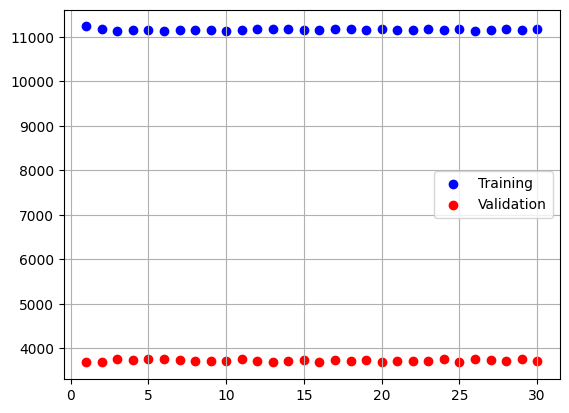

F1 Score: 0.018639798488664986
Confusion Matrix:
 [[ 0 36  0  0  0  0  0  0  0  0]
 [ 0 37  0  0  0  0  0  0  0  0]
 [ 0 35  0  0  0  0  0  0  0  0]
 [ 0 37  0  0  0  0  0  0  0  0]
 [ 0 36  0  0  0  0  0  0  0  0]
 [ 0 36  0  0  0  0  0  0  0  0]
 [ 0 36  0  0  0  0  0  0  0  0]
 [ 0 36  0  0  0  0  0  0  0  0]
 [ 0 35  0  0  0  0  0  0  0  0]
 [ 0 36  0  0  0  0  0  0  0  0]]


In [198]:
neural_network = Network()
neural_network.set_architecture(
    [To2D((10, 10, 1)),
    ConvLayer(1, 3, 4), 
    ActivationLayer(relu, relu_prime),
    ConvLayer(3, 9, 3), 
    ActivationLayer(relu, relu_prime),
    Flatten(),
    FCLayer(225, 10), 
    ActivationLayer(relu, relu_prime),
    ]
)
training(neural_network)
testing(neural_network)